# Re-producing the Shift data
from the study "Flying in 2050"

## Hypothesis

In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("./ipynb_inline.mplstyle")



In [40]:
import configparser

config = configparser.ConfigParser()

configfilename = "./aviation_parameters.ini"

config.read(configfilename)
    
config.sections()

['InitialState', 'ImpactCovid', 'referenceWord', 'ObjectifWord', 'simpleModel']

In [31]:
begin_year = float(config["InitialState"]["begin_year"])
emission_2018_fr = float(config["InitialState"]["emission_2018_fr"])
emission_2018_wd = float(config["InitialState"]["emission_2018_wd"])
budget_carbone_2018_50_fr = float(config["InitialState"]["budget_carbone_2018_50_fr"])
budget_carbone_2018_50_wd = float(config["InitialState"]["budget_carbone_2018_50_wd"])
years = np.arange(begin_year, 2051, 1. )

In [32]:
def traj_ref(config, years):
    """ creat the Reference trajectory 'business as usual' taking intoo account the Covid impact
    The coefficient are use to reproduce the impactes on the World market, starting in 2018"""
    traj = np.zeros_like(years)
    
    traj[0] = float(config["ImpactCovid"]["year_2018"])
    traj[1] = float(config["ImpactCovid"]["year_2019"])
    traj[2] = float(config["ImpactCovid"]["year_2020"])
    traj[3] = float(config["ImpactCovid"]["year_2021"])
    traj[4] = float(config["ImpactCovid"]["year_2022"])
    traj[5] = float(config["ImpactCovid"]["year_2023"])
    traj[6] = float(config["ImpactCovid"]["year_2024"])

    growthCoef = 1 + float(config["referenceWord"]["increaseTraficPerCent"])/100
    
    for index in np.arange(7, len(years)):
        traj[index] = traj[index-1]*growthCoef
    
    return traj

trajectory_ref_word = traj_ref(config, years)

def traj_objective(config, years):
    
    traj = np.zeros_like(years)
    growthCoef = 1 + float(config["ObjectifWord"]["increaseTraficPerCent"])/100

    traj[0] = float(config["InitialState"]["emission_2018_wd"])
    for index in np.arange(1, len(years)):
        traj[index] = traj[index-1]*growthCoef
        
    return traj
        
trajectory_obj_word = traj_objective(config, years)


In [34]:
from scipy.interpolate import make_interp_spline, BSpline

# 300 represents number of points to make between T.min and T.max
yearsnew = np.linspace(years.min(), years.max(), 300) 



Text(0, 0.5, 'Word emission [MtCO2]')

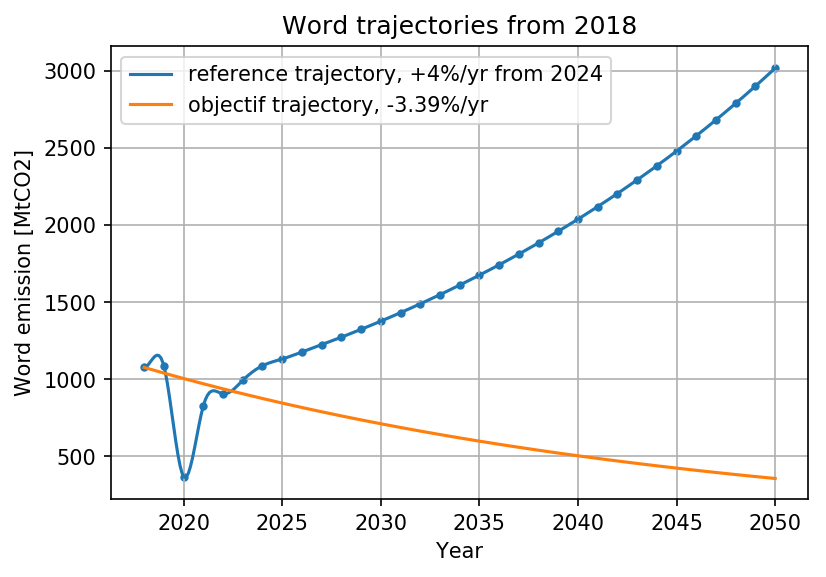

In [35]:
plt.figure()
spl = make_interp_spline(years, trajectory_ref_word, k=3, bc_type=([(1, 0.0)], [(2, 0.0)]))  # type: BSpline

plt.plot(yearsnew, spl(yearsnew), label="reference trajectory, +4%/yr from 2024")
plt.plot(years, trajectory_obj_word, label="objectif trajectory, -3.39%/yr")

plt.scatter(years, trajectory_ref_word, marker=".")
plt.legend()
plt.title("Word trajectories from 2018")
plt.xlabel("Year")
plt.ylabel("Word emission [MtCO2]")

In [41]:
optimisation_shortterm_operation = float(config["simpleModel"]["optimisation_shortterm_operation"])
optimisation_technologique = float(config["simpleModel"]["optimisation_technologique"])

In [42]:
def optimisation(trajectory, factor):
    """reduce the reference trajectory """
    
    factor_yearly = 1-(1-factor) ** (1/ (len(trajectory)) ) 
    print(factor_yearly)
    
    trajectory_opt = np.zeros_like(trajectory)
    
    for i in np.arange(len(trajectory)):
        trajectory_opt[i] = trajectory[i]* (1 - factor_yearly)**i
        
    return trajectory_opt

traj_operation_wd = optimisation(trajectory_ref_word, optimisation_shortterm_operation)
traj_techno_wd = optimisation(traj_operation_wd, optimisation_technologique)

(traj_operation_wd[-1] - traj_techno_wd[-1])/traj_operation_wd[-1]*100, (trajectory_ref_word[-1] - traj_operation_wd[-1])/trajectory_ref_word[-1]*100

0.003355918720319928
0.02078540275399865


(48.938669684231805, 10.198633914443047)

Text(0, 0.5, 'Word emission [MtCO2]')

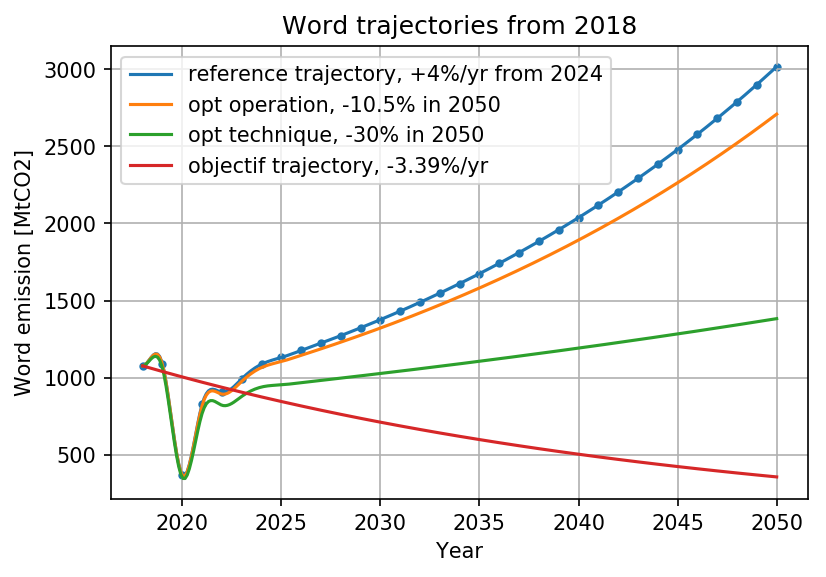

In [43]:
plt.figure()
spl_op = make_interp_spline(years, traj_operation_wd, k=3, bc_type=([(1, 0.0)], [(2, 0.0)]))  # type: BSpline
spl_tech = make_interp_spline(years, traj_techno_wd, k=3, bc_type=([(1, 0.0)], [(2, 0.0)]))  # type: BSpline

plt.scatter(years, trajectory_ref_word, marker=".")

plt.plot(yearsnew, spl(yearsnew), label="reference trajectory, +4%/yr from 2024")
plt.plot(yearsnew, spl_op(yearsnew), label="opt operation, -10.5% in 2050")
plt.plot(yearsnew, spl_tech(yearsnew), label="opt technique, -30% in 2050")
plt.plot(years, trajectory_obj_word, label="objectif trajectory, -3.39%/yr")

plt.legend()
plt.title("Word trajectories from 2018")
plt.xlabel("Year")
plt.ylabel("Word emission [MtCO2]")